In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# name of the notebook
name_notebook = "sweep_12h_e_Am_Xqm"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="Try to find the best measurement and number of layers for the quantum block using Amplitude Encoding and embedding.",
#     repetitions=list(range(1, 3)),
#     n_layers_quantum_block=[1,2,5,12,20],
#     n_qubits=[4,6],
#     qubits_measurement=[1, 'all'],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0912', initial_path=initial_path)



 --- SWEEP POINT 1/40: (1, 1, 4, 1) ---
 --- parameters sweeping: ['repetitions', 'n_layers_quantum_block', 'n_qubits', 'qubits_measurement'] 

Epoch [0/2], Loss epoch: 0.3548, Loss validation: 0.3554


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 3173; 	 prediction: -0.1521, 	 target: -0.2330, 	 loss: 0.0065
	 Validation string, 	 i: 1610; 	 prediction: -0.4016, 	 target: -0.4729, 	 loss: 0.0051
	 Validation string, 	 i: 3676; 	 prediction: -0.2794, 	 target: -0.1398, 	 loss: 0.0195
Epoch [1/2], Loss epoch: 0.0138, Loss validation: 0.0129, Time remaining: ~0.0h 5.0m 45s
	 Validation string, 	 i: 4289; 	 prediction: -0.1651, 	 target: -0.0004, 	 loss: 0.0271
	 Validation string, 	 i: 1469; 	 prediction: -0.2385, 	 target: -0.3059, 	 loss: 0.0045
	 Validation string, 	 i: 3386; 	 prediction: -0.1566, 	 target: -0.1191, 	 loss: 0.0014
Epoch [2/2], Loss epoch: 0.0123, Loss validation: 0.0120, Time remaining: ~0.0h 0.0m 0s


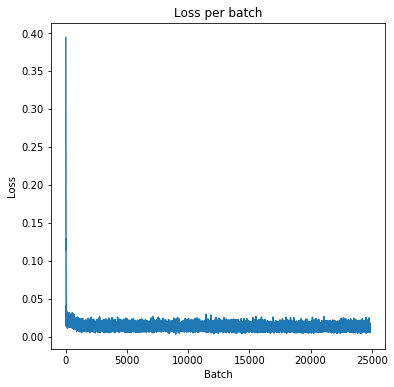

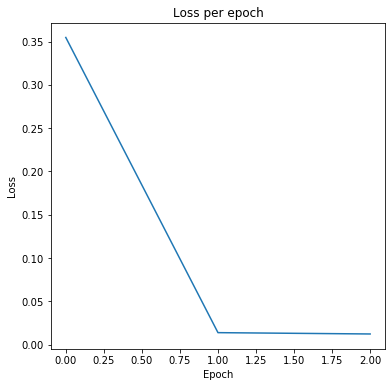

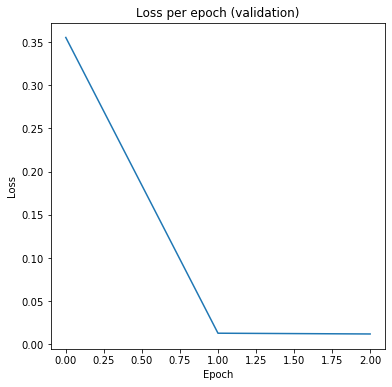

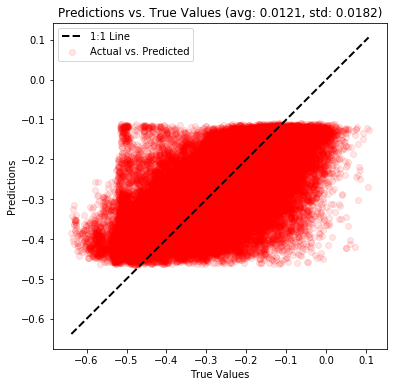

Mean loss: 0.012111820192489164, std loss: 0.0181903553212625


 --- SWEEP POINT 2/40: (1, 1, 4, 'all') ---
 --- time reamining: 1870:50:47.46 

Epoch [0/2], Loss epoch: 0.0341, Loss validation: 0.0343
	 Validation string, 	 i: 528; 	 prediction: -0.2231, 	 target: -0.1202, 	 loss: 0.0106
	 Validation string, 	 i: 172; 	 prediction: -0.1360, 	 target: -0.1783, 	 loss: 0.0018
	 Validation string, 	 i: 1388; 	 prediction: -0.2454, 	 target: -0.1302, 	 loss: 0.0133
Epoch [1/2], Loss epoch: 0.0102, Loss validation: 0.0095, Time remaining: ~0.0h 6.0m 4s
	 Validation string, 	 i: 3434; 	 prediction: -0.3644, 	 target: -0.1666, 	 loss: 0.0391
	 Validation string, 	 i: 3184; 	 prediction: -0.0973, 	 target: -0.1532, 	 loss: 0.0031
	 Validation string, 	 i: 281; 	 prediction: -0.3510, 	 target: -0.3493, 	 loss: 0.0000
Epoch [2/2], Loss epoch: 0.0096, Loss validation: 0.0097, Time remaining: ~0.0h 0.0m 0s


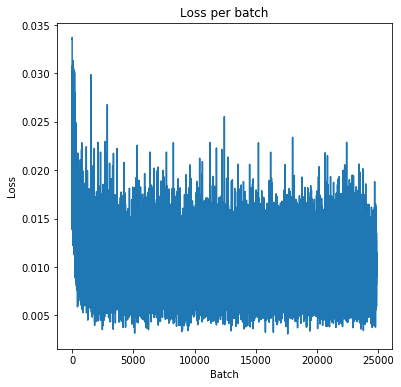

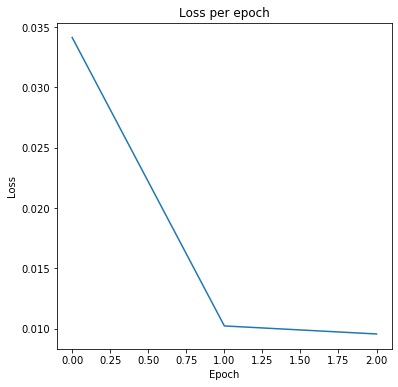

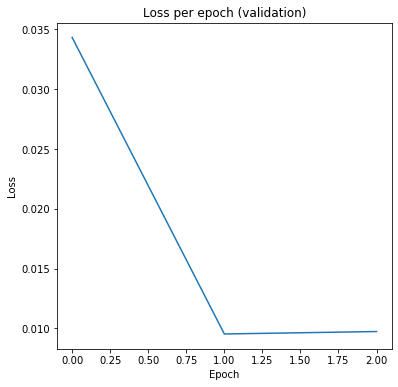

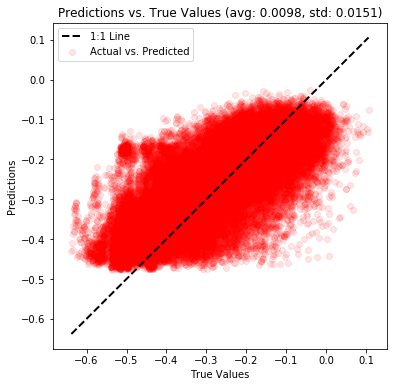

Mean loss: 0.009791241849089999, std loss: 0.01512020941342155


 --- SWEEP POINT 3/40: (1, 1, 6, 1) ---
 --- time reamining: 916:59:24.41 

Epoch [0/2], Loss epoch: 0.0914, Loss validation: 0.0917
	 Validation string, 	 i: 51; 	 prediction: -0.2862, 	 target: -0.4201, 	 loss: 0.0179
	 Validation string, 	 i: 1495; 	 prediction: -0.3512, 	 target: -0.3965, 	 loss: 0.0020
	 Validation string, 	 i: 2284; 	 prediction: -0.1112, 	 target: -0.1144, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0086, Loss validation: 0.0084, Time remaining: ~0.0h 7.0m 51s
	 Validation string, 	 i: 2462; 	 prediction: -0.1725, 	 target: -0.1222, 	 loss: 0.0025
	 Validation string, 	 i: 2586; 	 prediction: -0.3862, 	 target: -0.4829, 	 loss: 0.0093
	 Validation string, 	 i: 3834; 	 prediction: -0.1700, 	 target: -0.0734, 	 loss: 0.0093
Epoch [2/2], Loss epoch: 0.0083, Loss validation: 0.0087, Time remaining: ~0.0h 0.0m 0s


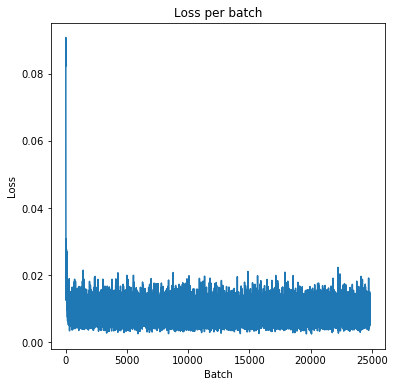

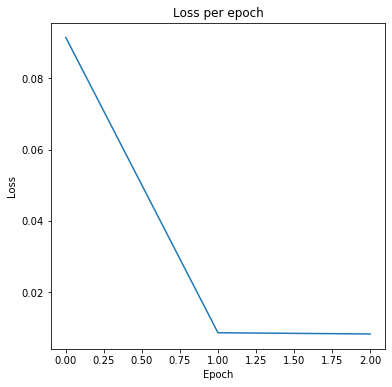

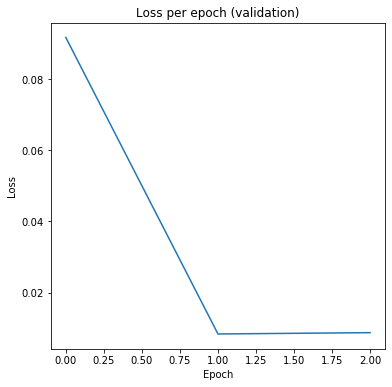

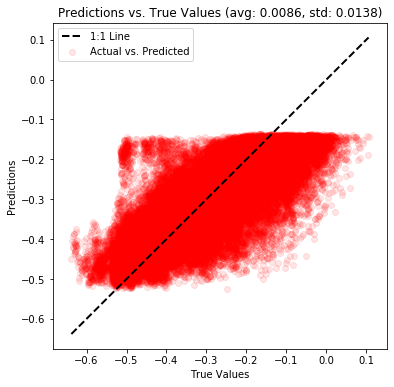

Mean loss: 0.00859063456212918, std loss: 0.013840275658983197


 --- SWEEP POINT 4/40: (1, 1, 6, 'all') ---
 --- time reamining: 600:30:46.06 

Epoch [0/2], Loss epoch: 0.2606, Loss validation: 0.2605
	 Validation string, 	 i: 354; 	 prediction: -0.3607, 	 target: -0.2255, 	 loss: 0.0183
	 Validation string, 	 i: 215; 	 prediction: -0.3710, 	 target: -0.5001, 	 loss: 0.0167
	 Validation string, 	 i: 274; 	 prediction: -0.2121, 	 target: -0.2360, 	 loss: 0.0006
Epoch [1/2], Loss epoch: 0.0081, Loss validation: 0.0078, Time remaining: ~0.0h 8.0m 41s
	 Validation string, 	 i: 1557; 	 prediction: -0.3851, 	 target: -0.3875, 	 loss: 0.0000
	 Validation string, 	 i: 2584; 	 prediction: -0.1273, 	 target: -0.0908, 	 loss: 0.0013
	 Validation string, 	 i: 1199; 	 prediction: -0.1379, 	 target: -0.2984, 	 loss: 0.0258
Epoch [2/2], Loss epoch: 0.0072, Loss validation: 0.0071, Time remaining: ~0.0h 0.0m 0s


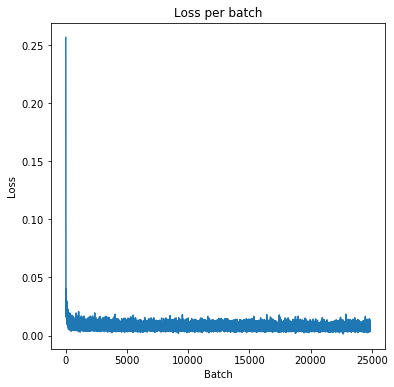

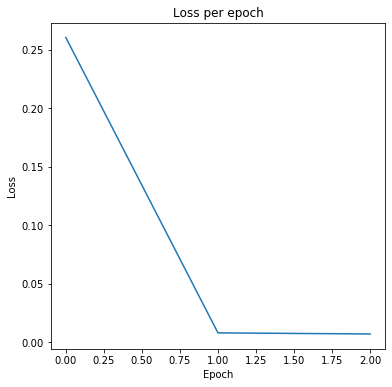

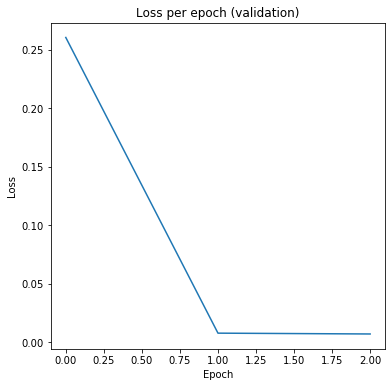

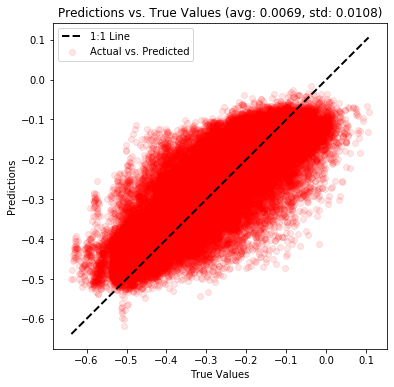

Mean loss: 0.006937313825913404, std loss: 0.010794989251030528


 --- SWEEP POINT 5/40: (1, 2, 4, 1) ---
 --- time reamining: 442:16:51.55 

Epoch [0/2], Loss epoch: 1.1473, Loss validation: 1.1482
	 Validation string, 	 i: 2995; 	 prediction: -0.4351, 	 target: -0.4829, 	 loss: 0.0023
	 Validation string, 	 i: 3553; 	 prediction: -0.1552, 	 target: -0.0974, 	 loss: 0.0033
	 Validation string, 	 i: 2885; 	 prediction: -0.3779, 	 target: -0.2154, 	 loss: 0.0264
Epoch [1/2], Loss epoch: 0.0127, Loss validation: 0.0088, Time remaining: ~0.0h 6.0m 55s
	 Validation string, 	 i: 503; 	 prediction: -0.2984, 	 target: -0.2268, 	 loss: 0.0051
	 Validation string, 	 i: 3693; 	 prediction: -0.2562, 	 target: -0.1582, 	 loss: 0.0096
	 Validation string, 	 i: 458; 	 prediction: -0.1695, 	 target: -0.1676, 	 loss: 0.0000
Epoch [2/2], Loss epoch: 0.0089, Loss validation: 0.0088, Time remaining: ~0.0h 0.0m 0s


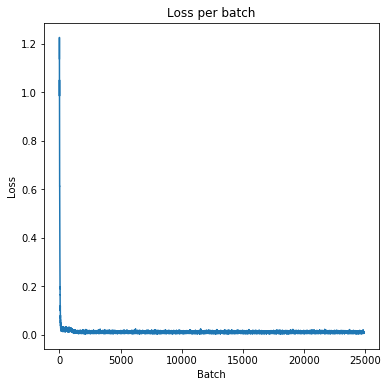

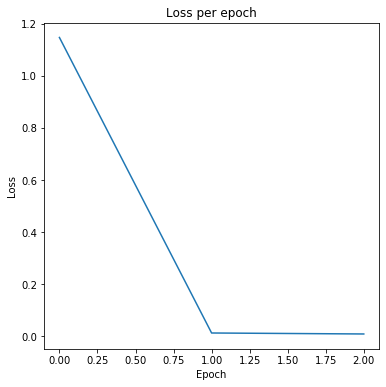

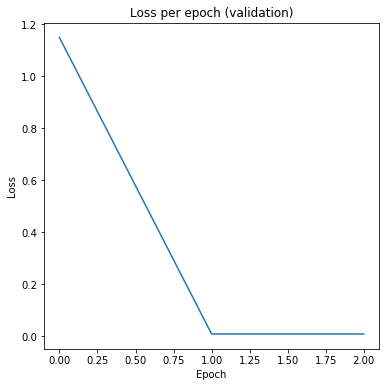

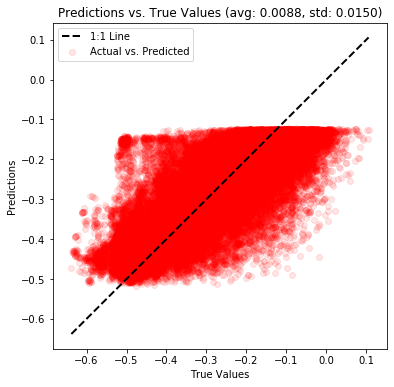

Mean loss: 0.008814872466093191, std loss: 0.014970971370057713


 --- SWEEP POINT 6/40: (1, 2, 4, 'all') ---
 --- time reamining: 346:29:12.00 

Epoch [0/2], Loss epoch: 0.3610, Loss validation: 0.3618
	 Validation string, 	 i: 3739; 	 prediction: -0.1611, 	 target: -0.1388, 	 loss: 0.0005
	 Validation string, 	 i: 3849; 	 prediction: -0.1318, 	 target: -0.1824, 	 loss: 0.0026
	 Validation string, 	 i: 3918; 	 prediction: -0.1432, 	 target: -0.0080, 	 loss: 0.0183
Epoch [1/2], Loss epoch: 0.0090, Loss validation: 0.0082, Time remaining: ~0.0h 7.0m 8s
	 Validation string, 	 i: 2487; 	 prediction: -0.2367, 	 target: -0.2405, 	 loss: 0.0000
	 Validation string, 	 i: 4226; 	 prediction: -0.1716, 	 target: -0.1624, 	 loss: 0.0001
	 Validation string, 	 i: 3718; 	 prediction: -0.1704, 	 target: -0.2007, 	 loss: 0.0009
Epoch [2/2], Loss epoch: 0.0080, Loss validation: 0.0081, Time remaining: ~0.0h 0.0m 0s


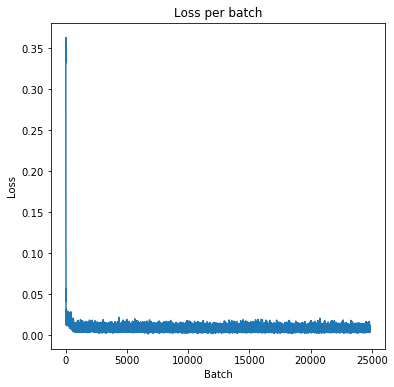

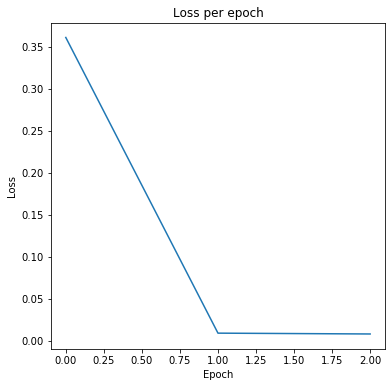

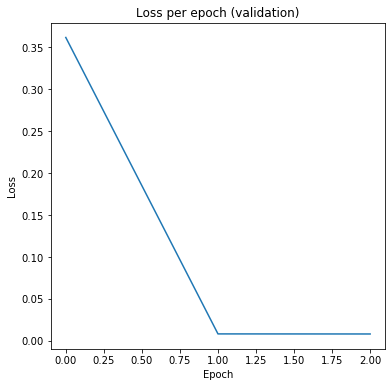

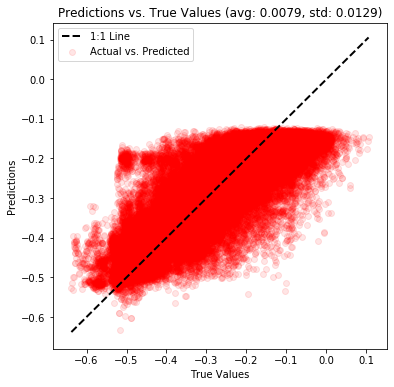

Mean loss: 0.007878206364114692, std loss: 0.012910635071397565


 --- SWEEP POINT 7/40: (1, 2, 6, 1) ---
 --- time reamining: 282:33:41.86 

Epoch [0/2], Loss epoch: 0.0508, Loss validation: 0.0510
	 Validation string, 	 i: 1254; 	 prediction: -0.4302, 	 target: -0.4796, 	 loss: 0.0024
	 Validation string, 	 i: 1006; 	 prediction: -0.4285, 	 target: -0.4813, 	 loss: 0.0028
	 Validation string, 	 i: 2336; 	 prediction: -0.1967, 	 target: -0.2926, 	 loss: 0.0092
Epoch [1/2], Loss epoch: 0.0085, Loss validation: 0.0088, Time remaining: ~0.0h 9.0m 52s
	 Validation string, 	 i: 1979; 	 prediction: -0.2393, 	 target: -0.0840, 	 loss: 0.0241
	 Validation string, 	 i: 1183; 	 prediction: -0.3995, 	 target: -0.4646, 	 loss: 0.0042
	 Validation string, 	 i: 3004; 	 prediction: -0.3735, 	 target: -0.2849, 	 loss: 0.0079
Epoch [2/2], Loss epoch: 0.0080, Loss validation: 0.0079, Time remaining: ~0.0h 0.0m 0s


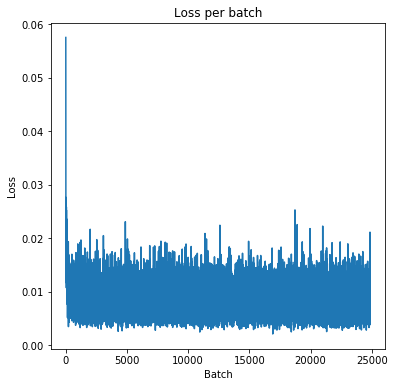

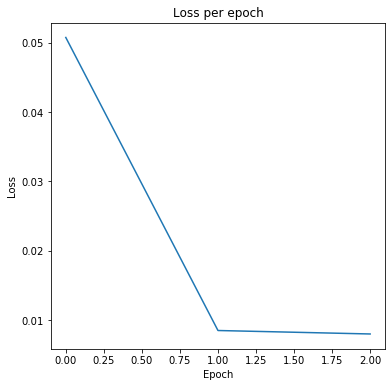

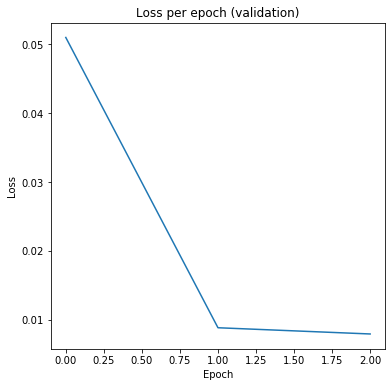

In [7]:
for sweep_point in sweep:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = sweep_point['n_qubits']
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AmplitudeEmbedding, 
        # embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11,
        measurement = q.parts.Measurement('Z', sweep_point['qubits_measurement']),
        # embedding_n_layers = 4,
        # different_inputs_per_layer = True,
        block_n_layers = sweep_point['n_layers_quantum_block'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            n_qubits_measured = n_qubits if sweep_point['qubits_measurement'] == 'all' else 1
            embedding_dim = 2**n_qubits//12
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=embedding_dim)
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer() 
            self.fc4 = m.nn.Linear(n_qubits_measured, n_qubits_measured) 
            self.fc5 = m.nn.Linear(n_qubits_measured, 1)

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            x = self.fc3(x)
            x = m.torch.sigmoid(self.fc4(x))
            x = self.fc5(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids and {} qubits using Amplitude Encoding and classical Embedding'.format(n_qubits),    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    